In [2]:
import os
import random
import torch
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# **Checking GPU**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 2060


# **Average Image Size**

In [3]:
def process_image(file_path):
    try:
        with Image.open(file_path) as img:
            width, height = img.size
            return width, height
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

def calculate_avg_dimensions(image_dir):
    total_width = 0
    total_height = 0
    image_count = 0

    with ThreadPoolExecutor() as executor:
        futures = []
        for file_name in os.listdir(image_dir):
            file_path = os.path.join(image_dir, file_name)
            if os.path.isfile(file_path) and file_name.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
                futures.append(executor.submit(process_image, file_path))

        for future in futures:
            result = future.result()
            if result:
                width, height = result
                total_width += width
                total_height += height
                image_count += 1

    if image_count == 0:
        return (0, 0)

    avg_width = total_width / image_count
    avg_height = total_height / image_count

    return avg_width, avg_height

train_dir = "D:\\Computer Vision\\FYP\\TASK 1\\env\\TrackNet-X\\DataSet\\VeRi\\image_train"
test_dir = "D:\\Computer Vision\\FYP\\TASK 1\\env\\TrackNet-X\\DataSet\\VeRi\\image_test"

train_avg_dimensions = calculate_avg_dimensions(train_dir)
test_avg_dimensions = calculate_avg_dimensions(test_dir)

print(f"Average dimensions in training images: {train_avg_dimensions}")
print(f"Average dimensions in test images: {test_avg_dimensions}")

Average dimensions in training images: (243.56360844936205, 214.27788660066705)
Average dimensions in test images: (243.71741946627515, 217.27705328612143)


# **Dataset Loading & Splitting**

In [4]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for img_name in os.listdir(image_dir):
            if img_name.lower().endswith(('png', 'jpg', 'jpeg')):
                img_path = os.path.join(image_dir, img_name)
                self.image_paths.append(img_path)

                label = img_name.split('_')[0]
                self.labels.append(int(label))
                
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
transform = transforms.Compose([transforms.Resize((243, 214)), transforms.ToTensor(),transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
# transform = transforms.Compose([transforms.Resize((243, 214)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dir = r"C:\Users\ahmad\Vision Project\env1\Custom-TrackNet-X\DataSet\VeRi\image_train"
dataset = CustomDataset(train_dir, transform=transform)

In [6]:
half_dataset = torch.utils.data.Subset(dataset, range(20000))
print((len(half_dataset)))

20000


In [7]:
for i in range(53,60):
    image, label = half_dataset[i]
    print(f"Image {i+1}: Label = {label}")

Image 54: Label = 1
Image 55: Label = 3
Image 56: Label = 3
Image 57: Label = 3
Image 58: Label = 3
Image 59: Label = 3
Image 60: Label = 3


In [8]:
train_set, val_set = train_test_split(half_dataset, test_size=0.25, random_state=42)

In [9]:
train_set_sorted = sorted(train_set, key=lambda x: x[1])
val_set_sorted = sorted(val_set, key=lambda x: x[1])
for i in range(48,59):
    image, label = train_set_sorted[i]
    print(f"Train Image {i+1}: Train Label = {label}")
for j in range(48,59):
    img, lbl = val_set_sorted[j]
    print(f"Test Image {j+1}: Test Label = {lbl}")


train_labels = [label for _, label in train_set_sorted]
unique_train_labels = set(train_labels)
print(f"Unique Train Labels: {unique_train_labels}")

val_labels = [label for _, label in val_set_sorted]
unique_val_labels = set(val_labels)
print(f"Unique Test Labels: {unique_val_labels}")

Train Image 49: Train Label = 3
Train Image 50: Train Label = 3
Train Image 51: Train Label = 3
Train Image 52: Train Label = 3
Train Image 53: Train Label = 3
Train Image 54: Train Label = 3
Train Image 55: Train Label = 3
Train Image 56: Train Label = 3
Train Image 57: Train Label = 3
Train Image 58: Train Label = 3
Train Image 59: Train Label = 3
Test Image 49: Test Label = 8
Test Image 50: Test Label = 8
Test Image 51: Test Label = 10
Test Image 52: Test Label = 10
Test Image 53: Test Label = 10
Test Image 54: Test Label = 10
Test Image 55: Test Label = 10
Test Image 56: Test Label = 10
Test Image 57: Test Label = 10
Test Image 58: Test Label = 10
Test Image 59: Test Label = 11
Unique Train Labels: {1, 3, 4, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 36, 37, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 64, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 91, 

In [10]:
print(len(train_set), len(val_set))

15000 5000


# **Custom CNN**

In [11]:
# class CustomCNN(nn.Module):
#     def __init__(self):
#         super(CustomCNN, self).__init__()
        
#         # First convolution layer: 7x7 kernel, stride 5, zero padding, 12 channels
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=7, stride=5, padding=0)
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         # Second convolution layer: 3x3 kernel, stride 1, 24 channels
#         self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1)
        
#         # Third convolution layer: 3x3 kernel, stride 2, 32 channels
#         self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, stride=2)
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         # Fourth convolution layer: 3x3 kernel, stride 2, 64 channels
#         self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
#         self.pool3 = nn.MaxPool2d(kernel_size=3, stride=3)
        
#         # Adaptive pooling or Flatten for embedding output
#         self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Flatten()

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = self.pool1(x)
        
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = self.pool2(x)
        
#         x = F.relu(self.conv4(x))
#         x = self.pool3(x)
        
#         x = self.global_pool(x)
#         x = self.fc(x)
#         return x

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        # First convolution layer: 7x7 kernel, stride 5, padding 3, 12 channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=7, stride=5, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolution layer: 3x3 kernel, stride 1, padding 1, 24 channels
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # Third convolution layer: 3x3 kernel, stride 2, padding 1, 32 channels
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fourth convolution layer: 3x3 kernel, stride 2, padding 1, 64 channels
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        
        # Adaptive pooling to prevent size issues
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv4(x))
        x = self.global_pool(x)
        x = self.fc(x)
        return x

# **Loss Function**

In [12]:
def triplet_loss(anchor, positive, negative, margin=1.0):
    """
    Compute the triplet loss:
    Loss = max(||anchor - positive||^2 - ||anchor - negative||^2 + margin, 0)
    """
    positive_dist = F.pairwise_distance(anchor, positive, p=2)
    negative_dist = F.pairwise_distance(anchor, negative, p=2)
    loss = torch.relu(positive_dist - negative_dist + margin)
    return loss.mean()

In [13]:
def generate_triplets(dataset):
    anchors, positives, negatives = [], [], []
    class_dict = {}

    for i in range(len(dataset)):
        _, label = dataset[i]
        if label not in class_dict:
            class_dict[label] = []
        class_dict[label].append(i)

    for label in class_dict:
        if len(class_dict[label]) < 2:
            continue
        for i in range(len(class_dict[label])):
            anchor_idx = class_dict[label][i]
            positive_idx = random.choice(class_dict[label])  # Pick a random positive
            negative_label = random.choice(list(class_dict.keys() - {label}))  # Pick a random different label
            negative_idx = random.choice(class_dict[negative_label])

            anchors.append(anchor_idx)
            positives.append(positive_idx)
            negatives.append(negative_idx)

    return anchors, positives, negatives

In [14]:
train_anchors, train_positives, train_negatives = generate_triplets(train_set)
val_anchors, val_positives, val_negatives = generate_triplets(val_set)

In [15]:
train_loader = DataLoader([(train_set[a][0], train_set[p][0], train_set[n][0]) for a, p, n in zip(train_anchors, train_positives, train_negatives)], batch_size=16, shuffle=True)
val_loader = DataLoader([(val_set[a][0], val_set[p][0], val_set[n][0]) for a, p, n in zip(val_anchors, val_positives, val_negatives)], batch_size=16, shuffle=False)

In [16]:
def plot_learning_curves(train_losses, val_losses, val_accuracies, train_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 6))

    # Plot training and validation losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# **Training**

In [18]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs, margin):
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (anchors, positives, negatives) in enumerate(train_loader):
            anchors, positives, negatives = (
                anchors.to(device),
                positives.to(device),
                negatives.to(device),
            )

            optimizer.zero_grad()
            anchor_embeds = model(anchors)
            positive_embeds = model(positives)
            negative_embeds = model(negatives)
            loss = triplet_loss(anchor_embeds, positive_embeds, negative_embeds, margin)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate training accuracy (anchor-positive distance < anchor-negative distance)
            distances_positive = torch.pairwise_distance(anchor_embeds, positive_embeds)
            distances_negative = torch.pairwise_distance(anchor_embeds, negative_embeds)
            correct_train += (distances_positive < distances_negative).sum().item()
            total_train += len(distances_positive)

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train if total_train > 0 else 0
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation step
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (anchors, positives, negatives) in enumerate(val_loader):
                anchors, positives, negatives = (anchors.to(device), positives.to(device), negatives.to(device),)
                anchor_embeds = model(anchors)
                positive_embeds = model(positives)
                negative_embeds = model(negatives)
                loss = triplet_loss(anchor_embeds, positive_embeds, negative_embeds, margin)
                val_loss += loss.item()

                distances = torch.pairwise_distance(anchor_embeds, positive_embeds)
                predicted = (distances < margin).float()
                correct += (predicted == 1).sum().item()
                total += len(predicted)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total if total > 0 else 0
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    plot_learning_curves(train_losses, val_losses, val_accuracies, train_accuracies)

Epoch [1/20], Train Loss: 0.7895, Train Accuracy: 71.41%, Validation Loss: 0.7881, Validation Accuracy: 100.00%
Epoch [2/20], Train Loss: 0.7893, Train Accuracy: 71.33%, Validation Loss: 0.7879, Validation Accuracy: 100.00%
Epoch [3/20], Train Loss: 0.7890, Train Accuracy: 71.35%, Validation Loss: 0.7876, Validation Accuracy: 100.00%
Epoch [4/20], Train Loss: 0.7888, Train Accuracy: 71.32%, Validation Loss: 0.7873, Validation Accuracy: 100.00%
Epoch [5/20], Train Loss: 0.7885, Train Accuracy: 71.40%, Validation Loss: 0.7870, Validation Accuracy: 100.00%
Epoch [6/20], Train Loss: 0.7882, Train Accuracy: 71.33%, Validation Loss: 0.7867, Validation Accuracy: 100.00%
Epoch [7/20], Train Loss: 0.7879, Train Accuracy: 71.41%, Validation Loss: 0.7864, Validation Accuracy: 100.00%
Epoch [8/20], Train Loss: 0.7876, Train Accuracy: 71.39%, Validation Loss: 0.7860, Validation Accuracy: 100.00%
Epoch [9/20], Train Loss: 0.7873, Train Accuracy: 71.33%, Validation Loss: 0.7857, Validation Accuracy: 

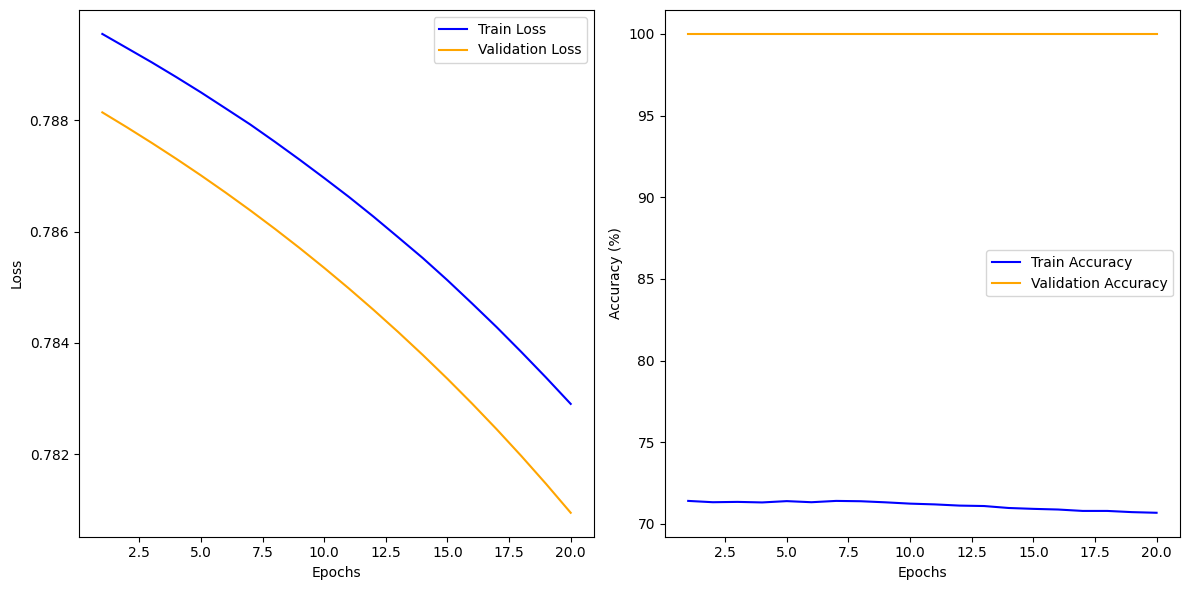

In [19]:
model = CustomCNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.0001)
train_model(model, train_loader, val_loader, optimizer, num_epochs=20, margin=0.8)

Epoch [1/20], Train Loss: 0.6616, Train Accuracy: 66.74%, Validation Loss: 0.5439, Validation Accuracy: 81.83%
Epoch [2/20], Train Loss: 0.5150, Train Accuracy: 72.06%, Validation Loss: 0.4721, Validation Accuracy: 65.63%
Epoch [3/20], Train Loss: 0.4608, Train Accuracy: 74.81%, Validation Loss: 0.4338, Validation Accuracy: 61.95%
Epoch [4/20], Train Loss: 0.4252, Train Accuracy: 76.71%, Validation Loss: 0.4053, Validation Accuracy: 61.93%
Epoch [5/20], Train Loss: 0.4021, Train Accuracy: 78.37%, Validation Loss: 0.3872, Validation Accuracy: 60.37%
Epoch [6/20], Train Loss: 0.3867, Train Accuracy: 79.23%, Validation Loss: 0.3734, Validation Accuracy: 59.73%
Epoch [7/20], Train Loss: 0.3744, Train Accuracy: 79.84%, Validation Loss: 0.3619, Validation Accuracy: 56.91%
Epoch [8/20], Train Loss: 0.3616, Train Accuracy: 80.59%, Validation Loss: 0.3476, Validation Accuracy: 57.39%
Epoch [9/20], Train Loss: 0.3472, Train Accuracy: 81.17%, Validation Loss: 0.3317, Validation Accuracy: 56.63%
E

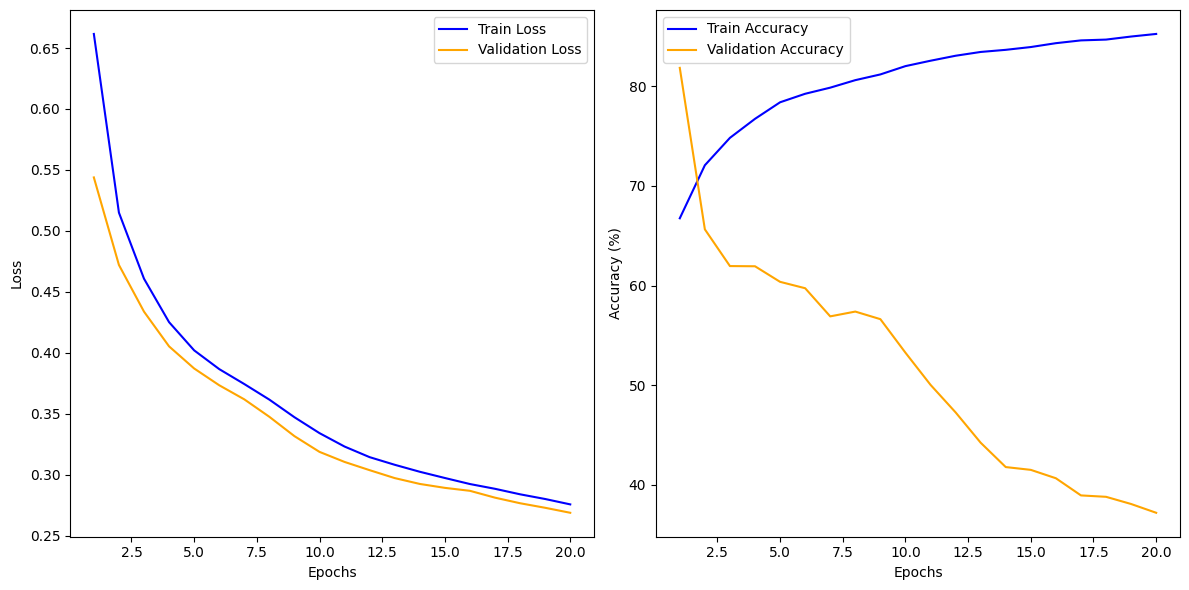

In [21]:
model = CustomCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.00001)
train_model(model, train_loader, val_loader, optimizer, num_epochs=20, margin=0.8)

Epoch [1/15], Train Loss: 0.6507, Train Accuracy: 67.95%, Validation Loss: 0.5716, Validation Accuracy: 77.04%
Epoch [2/15], Train Loss: 0.5747, Train Accuracy: 68.09%, Validation Loss: 0.5433, Validation Accuracy: 80.38%
Epoch [3/15], Train Loss: 0.4945, Train Accuracy: 73.64%, Validation Loss: 0.4226, Validation Accuracy: 75.90%
Epoch [4/15], Train Loss: 0.3931, Train Accuracy: 79.17%, Validation Loss: 0.3602, Validation Accuracy: 70.72%
Epoch [5/15], Train Loss: 0.3564, Train Accuracy: 80.88%, Validation Loss: 0.3381, Validation Accuracy: 64.49%
Epoch [6/15], Train Loss: 0.3427, Train Accuracy: 81.32%, Validation Loss: 0.3307, Validation Accuracy: 60.59%
Epoch [7/15], Train Loss: 0.3355, Train Accuracy: 81.62%, Validation Loss: 0.3211, Validation Accuracy: 58.75%
Epoch [8/15], Train Loss: 0.3291, Train Accuracy: 82.29%, Validation Loss: 0.3173, Validation Accuracy: 57.77%
Epoch [9/15], Train Loss: 0.3235, Train Accuracy: 82.58%, Validation Loss: 0.3120, Validation Accuracy: 58.37%
E

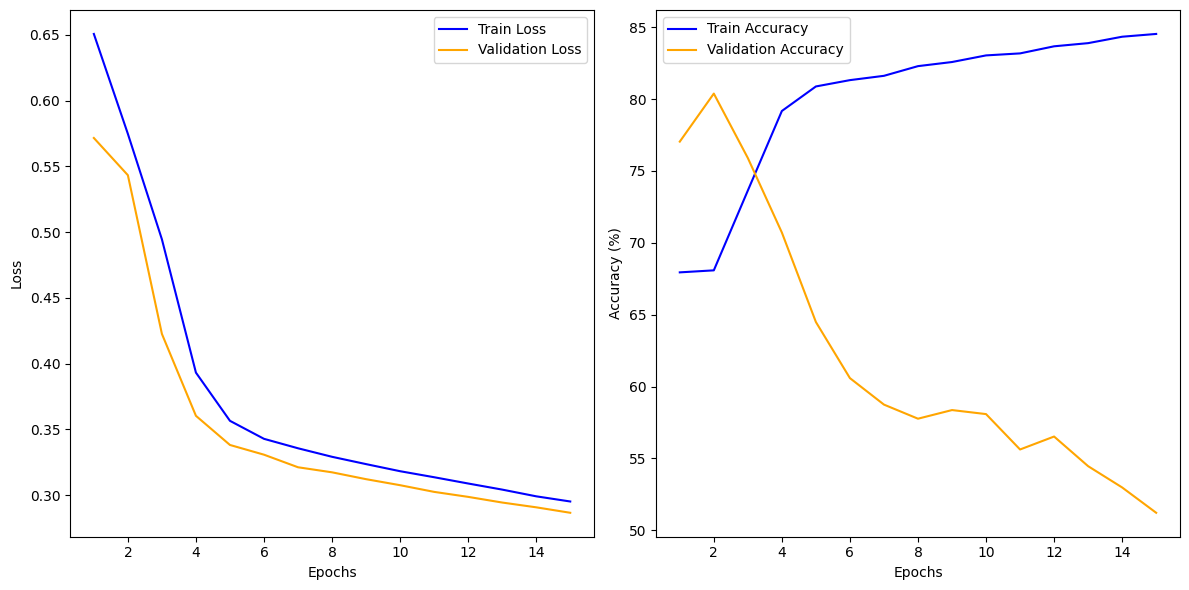

In [22]:
model = CustomCNN().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.00001)
train_model(model, train_loader, val_loader, optimizer, num_epochs=15, margin=0.8)

Epoch [1/15], Train Loss: 0.6568, Train Accuracy: 67.92%, Validation Loss: 0.5619, Validation Accuracy: 80.86%
Epoch [2/15], Train Loss: 0.5655, Train Accuracy: 68.37%, Validation Loss: 0.5368, Validation Accuracy: 82.27%
Epoch [3/15], Train Loss: 0.5086, Train Accuracy: 72.47%, Validation Loss: 0.4484, Validation Accuracy: 76.44%
Epoch [4/15], Train Loss: 0.4243, Train Accuracy: 77.01%, Validation Loss: 0.3962, Validation Accuracy: 68.27%
Epoch [5/15], Train Loss: 0.3886, Train Accuracy: 79.11%, Validation Loss: 0.3676, Validation Accuracy: 62.83%
Epoch [6/15], Train Loss: 0.3687, Train Accuracy: 80.02%, Validation Loss: 0.3507, Validation Accuracy: 61.53%
Epoch [7/15], Train Loss: 0.3534, Train Accuracy: 80.96%, Validation Loss: 0.3367, Validation Accuracy: 58.73%
Epoch [8/15], Train Loss: 0.3416, Train Accuracy: 81.45%, Validation Loss: 0.3264, Validation Accuracy: 57.67%
Epoch [9/15], Train Loss: 0.3328, Train Accuracy: 82.17%, Validation Loss: 0.3182, Validation Accuracy: 57.19%
E

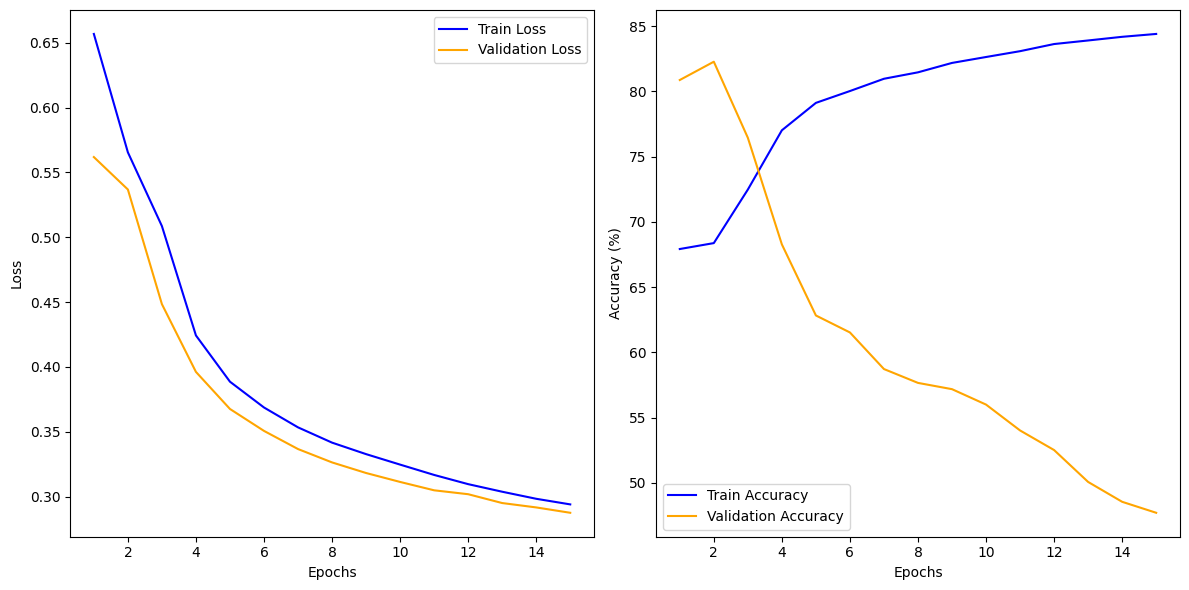

In [23]:
model = CustomCNN().to(device)
optimizer = optim.NAdam(model.parameters(), lr=0.00001, weight_decay=0.00001)
train_model(model, train_loader, val_loader, optimizer, num_epochs=15, margin=0.8)